## TIME SERIES ANALYSIS FOR WALMART STORES DATASET

#### Importing libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

#### Reading file and cleaning columns that won't be used

In [2]:
df_walmart = pd.read_csv('Walmart.csv')

In [3]:
df_walmart['Date'] = pd.to_datetime(df_walmart['Date'], format = "%d-%m-%Y")

In [4]:
store_sales = df_walmart[['Store','Weekly_Sales']]

In [5]:
store_sales = store_sales.groupby(by='Store').sum()

In [6]:
store_sales['participation'] = store_sales['Weekly_Sales']/store_sales['Weekly_Sales'].sum()
store_sales['Store'] = store_sales.index

In [7]:
store_sales_bars = store_sales[['Store','participation']].sort_values('participation',ascending = False)

In [8]:
store_sales_bars = store_sales_bars.reset_index(drop = True)

In [9]:
store_sales_bars['Store'] = store_sales_bars['Store'].astype('str')

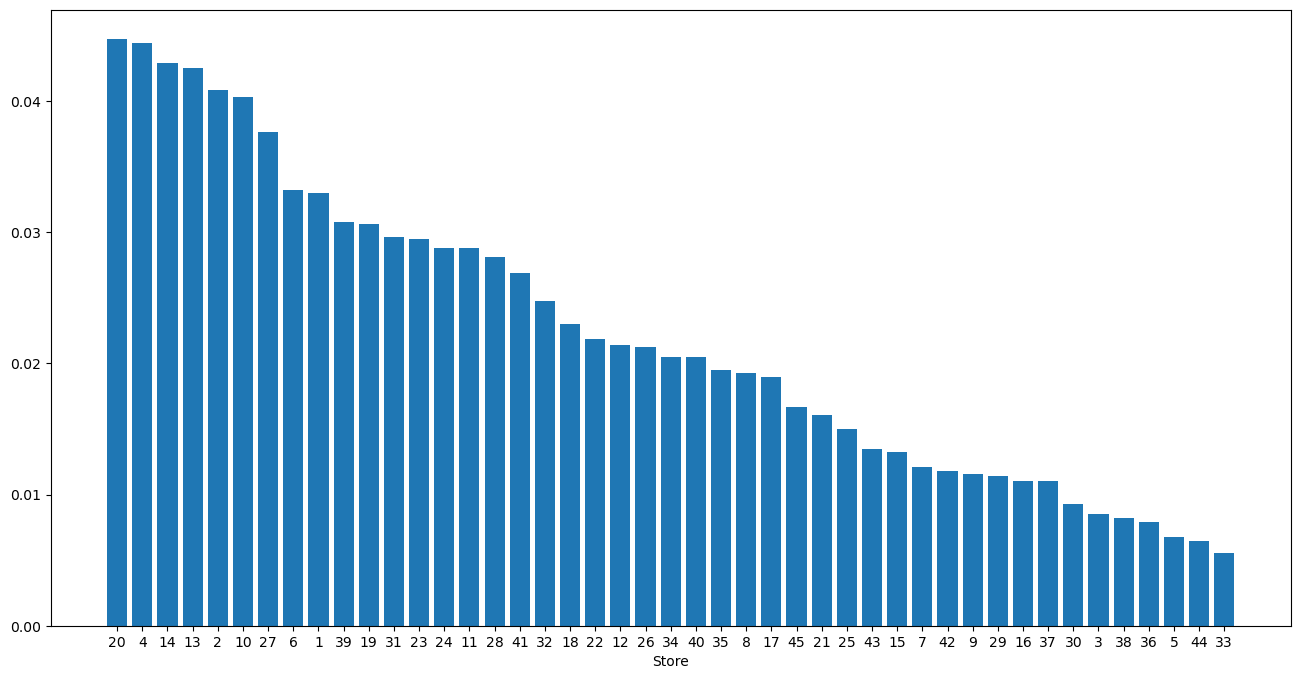

In [10]:
fig, ax = plt.subplots(figsize = (16,8))
plt.bar(x = store_sales_bars.Store, height = store_sales_bars.participation)
ax.set_xticks(store_sales_bars.Store)
plt.xlabel('Store')
plt.show()

## TOP -> DOWN STRATEGY
In order to assign a forecast for each store, it would be good to find the participation of each store in sales. This is called an ABC analysis where the higher amount of sales are produced by a small part of the total stores. However, in this case, we see in the graph from above that there is not a remarked difference. 

In [195]:
sales_week = df_walmart[['Date','Weekly_Sales']]

In [196]:
sales_week = sales_week.groupby(by="Date").sum()

In [197]:
sales_week.shape ## There are 143 stores registered then

(143, 1)

In [198]:
holidays = df_walmart[['Date','Holiday_Flag']] ## looking for weeks with holiday flags

In [199]:
holidays = holidays.groupby(by="Date").mean() 
## Since each store has the very same date, the mean will always be either 1 or 0. 

In [215]:
forecast = sales_week.merge(holidays,on=sales_week.index)

In [216]:
forecast

,key_0,Weekly_Sales,Holiday_Flag
0,2010-02-05,49750740.50,0.0
1,2010-02-12,48336677.63,1.0
2,2010-02-19,48276993.78,0.0
3,2010-02-26,43968571.13,0.0
4,2010-03-05,46871470.30,0.0
...,...,...,...
138,2012-09-28,43734899.40,0.0
139,2012-10-05,47566639.31,0.0
140,2012-10-12,46128514.25,0.0
141,2012-10-19,45122410.57,0.0


In [217]:
forecast = forecast.rename(columns = {'key_0' : 'Date'})

In [218]:
forecast['Date'] = pd.to_datetime(forecast['Date'], format = '%d-%m-%Y')

In [219]:
forecast = forecast.set_index('Date') ## This step helps the model identify dates

In [220]:
forecast['week'] = forecast.index.week

C:\Users\Hp\AppData\Local\Temp\ipykernel_11848\1259023049.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  forecast['week'] = forecast.index.week


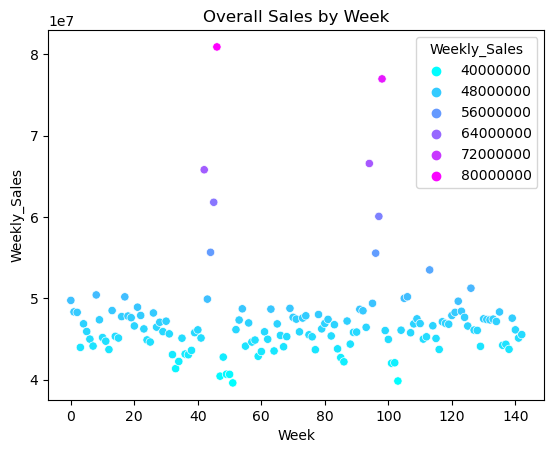

In [206]:
sns.scatterplot(data=forecast, x=range(len(forecast.index)), y = 'Weekly_Sales', palette = 'cool', hue= 'Weekly_Sales').set(title = 'Overall Sales by Week')
plt.xlabel('Week')
plt.show()

## Libraries for forecasting

In [30]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

## Training the model:
For training we will use the date may 25th and before. This is used to help our model to better predict the next events. The more data we use the better. In this case, for time series analysis it is better to have 2 cycles of data for each date at least. 

## Testing the model:
The other dates will be used for testing our model by comparing predictions with real data. Exact forecasting is almost impossible, but feeding the model will help to better predict and take better decisions. 

In [221]:
train_1 = forecast.loc[forecast.index<="2012-05-25"] #train dataframe table
test_1 = forecast.loc[forecast.index>"2012-05-25"] # test dataframe table

In [222]:
target = "Weekly_Sales" # Our target variable
features = ['Holiday_Flag', 'week']

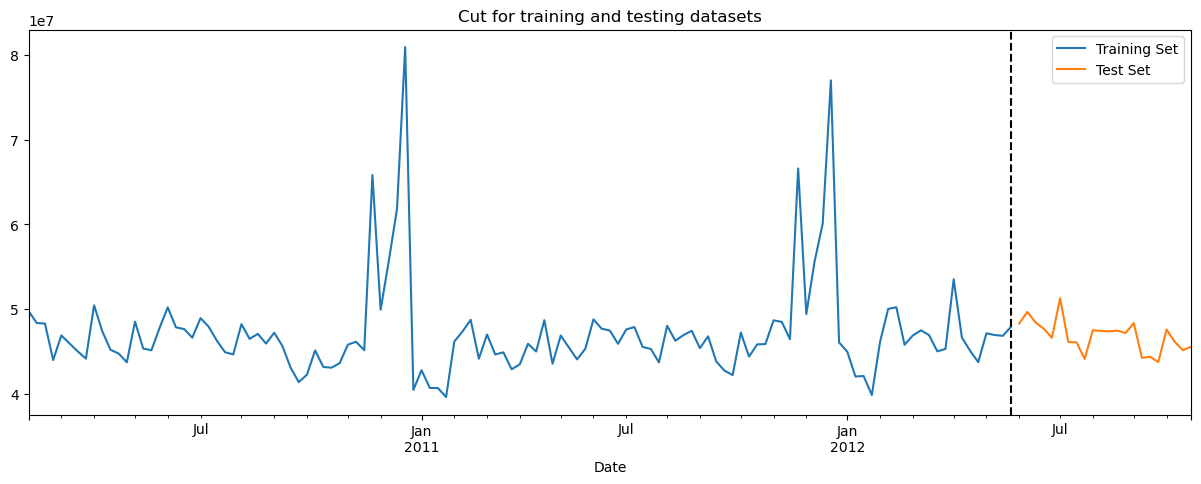

In [209]:
fig, ax = plt.subplots(figsize = (15,5))
train_1['Weekly_Sales'].plot(ax = ax, label = 'Training Set')
test_1['Weekly_Sales'].plot(ax = ax, label = 'Test Set')
ax.set_title('Cut for training and testing datasets')
ax.axvline('2012-05-25', color = 'black', ls = '--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [210]:
x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

#### Running first model

In [211]:
reg = xgb.XGBRegressor(n_estimators = 10000, #esstimations made. More stimations means more resources but less RMSE
                       early_stopping_rounds = 50, #Stops model training when Root Mean Square Error RMSE tends to a value
                       learning_rate=0.001)
reg.fit(x_train, y_train,
       eval_set= [(x_train,y_train), (x_test,y_test)],
       verbose=100) ## Showing model fitting each 100 estimators instead of the 10K estimators status

[0]	validation_0-rmse:47481577.00177	validation_1-rmse:46806020.23307
[100]	validation_0-rmse:43067664.03850	validation_1-rmse:42358516.45562
[200]	validation_0-rmse:39078020.14353	validation_1-rmse:38331896.89667
[300]	validation_0-rmse:35473281.63514	validation_1-rmse:34686483.81893
[400]	validation_0-rmse:32214990.75964	validation_1-rmse:31493559.44323
[500]	validation_0-rmse:29266228.61792	validation_1-rmse:28622389.84199
[600]	validation_0-rmse:26596636.14646	validation_1-rmse:26023226.61079
[700]	validation_0-rmse:24179806.73666	validation_1-rmse:23670481.44858
[800]	validation_0-rmse:21992613.85875	validation_1-rmse:21541011.98200
[900]	validation_0-rmse:20014112.58320	validation_1-rmse:19613846.88698
[1000]	validation_0-rmse:18225325.49011	validation_1-rmse:17865524.10536
[1100]	validation_0-rmse:16608246.65355	validation_1-rmse:16263851.17984
[1200]	validation_0-rmse:15147038.88648	validation_1-rmse:14814659.14654
[1300]	validation_0-rmse:13827771.33989	validation_1-rmse:13503

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [223]:
test_1['prediction'] = reg.predict(x_test)

C:\Users\Hp\AppData\Local\Temp\ipykernel_11848\2307747433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['prediction'] = reg.predict(x_test)


In [225]:
forecast = forecast.merge(test_1['prediction'], how= 'left', left_index = True, right_index = True)

In [226]:
forecast

,Weekly_Sales,Holiday_Flag,week,prediction
Date,,,,
2010-02-05,49750740.50,0.0,5,NaN
2010-02-12,48336677.63,1.0,6,NaN
2010-02-19,48276993.78,0.0,7,NaN
2010-02-26,43968571.13,0.0,8,NaN
2010-03-05,46871470.30,0.0,9,NaN
...,...,...,...,...
2012-09-28,43734899.40,0.0,39,42312684.0
2012-10-05,47566639.31,0.0,40,45785104.0
2012-10-12,46128514.25,0.0,41,43984288.0


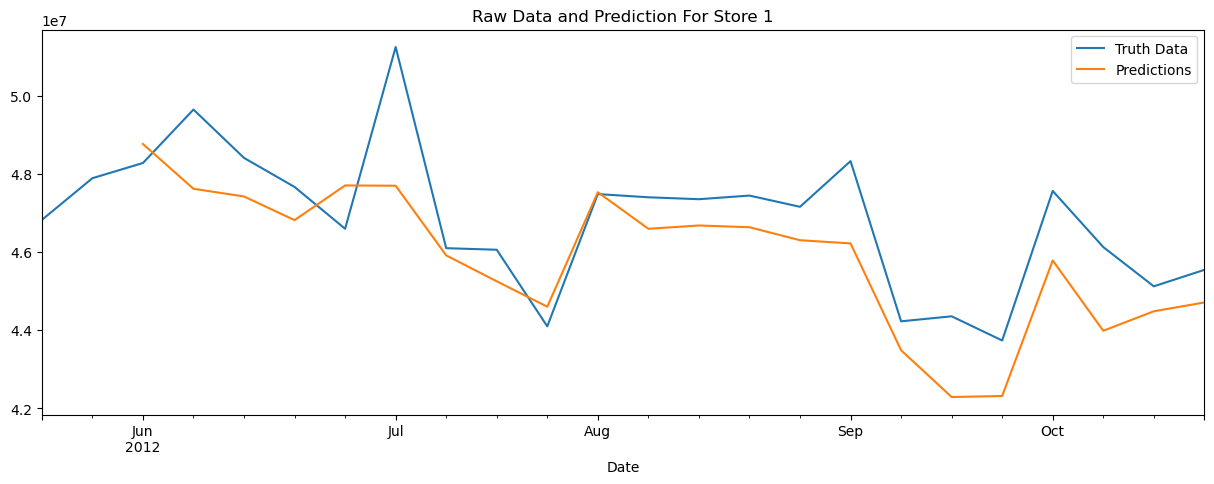

In [227]:
ax = forecast[['Weekly_Sales']][119:].plot(figsize = (15,5))
forecast['prediction'][119:].plot(ax=ax)
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Prediction For Store 1')
plt.show()

In [228]:
forecast = forecast.drop(['Weekly_Sales','Holiday_Flag','week'], axis = 1)

## Holt Winters Model

This is a model that takes into account different parameters for forecasting like trend, level and seasonality. So let's take a look and see if we can get a preciser forecast. 

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [239]:
forecast_HW = sales_week

In [240]:
train_2 = forecast_HW.loc[forecast_HW.index<="2012-05-25"] #train dataframe table
test_2 = forecast_HW.loc[forecast_HW.index>"2012-05-25"] # test dataframe table

In [242]:
model = ExponentialSmoothing(train_2, seasonal='add', seasonal_periods=52).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [244]:
test_2['prediction'] = pred

C:\Users\Hp\AppData\Local\Temp\ipykernel_11848\2679079538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2['prediction'] = pred


In [250]:
forecast_HW = forecast_HW.merge(test_2['prediction'], how= 'left', left_index = True, right_index = True)

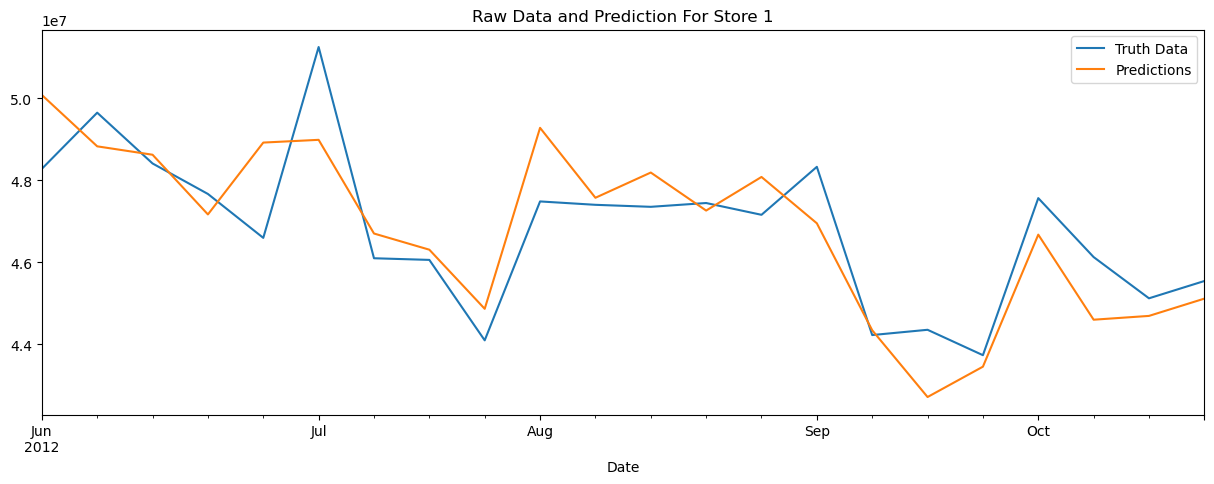

In [246]:
ax = test_2[['Weekly_Sales']].plot(figsize = (15,5))
test_2['prediction'].plot(ax=ax)
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Prediction For Store 1')
plt.show()

In [113]:
from statsmodels.tools.eval_measures import rmse

In [247]:
error = rmse(test.Weekly_Sales, test.prediction)

In [248]:
error

1143789.267345268

# Creating Data for Tableau Dashboard

In [132]:
store_sales = store_sales.reset_index(drop = True)

In [229]:
tableau_df = df_walmart.merge(store_sales, on = 'Store', how = 'left')

In [233]:
tableau_df.head()

,Store,Date,Weekly_Sales_x,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales_y,participation,prediction
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2.224028e+08,0.033011,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2.224028e+08,0.033011,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2.224028e+08,0.033011,NaN
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2.224028e+08,0.033011,NaN
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2.224028e+08,0.033011,NaN


## Adding Regression Forecast to our Tableau dpredictionata file

In [232]:
tableau_df = tableau_df.merge(forecast, on = 'Date', how = 'left')

In [234]:
tableau_df['Forecast Regression'] = tableau_df['prediction'] * tableau_df['participation']

In [235]:
for e, i in enumerate(tableau_df['Forecast Regression']):
    if math.isnan(i):
        tableau_df['Forecast Regression'][e] = tableau_df['Weekly_Sales_x'][e]

C:\Users\Hp\AppData\Local\Temp\ipykernel_11848\824941133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tableau_df['Forecast Regression'][e] = tableau_df['Weekly_Sales_x'][e]


#### _Partially Cleaning our data_
It's almost done, but we can start taking off columns

In [237]:
tableau_df = tableau_df.drop(['Weekly_Sales_y', 'prediction'], axis = 1)

## Adding our last model for Tableau

In [253]:
tableau_df = tableau_df.merge(forecast_HW, on = 'Date', how = 'left')

In [255]:
tableau_df['Holt Winter Forecast'] = tableau_df['prediction'] * tableau_df['participation']
for e, i in enumerate(tableau_df['Holt Winter Forecast']):
    if math.isnan(i):
        tableau_df['Holt Winter Forecast'][e] = tableau_df['Weekly_Sales_x'][e]

C:\Users\Hp\AppData\Local\Temp\ipykernel_11848\1115355487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tableau_df['Holt Winter Forecast'][e] = tableau_df['Weekly_Sales_x'][e]


### LAST CLEANING AND MEASURES

Introducing measures to visualize precision of each forecast 

In [258]:
tableau_df = tableau_df.drop(['Weekly_Sales','prediction', 'participation'],axis=1)

In [263]:
tableau_df = tableau_df.rename(columns= {'Weekly_Sales_x':'Weekly Sales'})
tableau_df['Holt Winter Difference'] = abs(tableau_df['Holt Winter Forecast'] - tableau_df['Weekly Sales'])
tableau_df['Regression Difference'] = abs(tableau_df['Forecast Regression'] - tableau_df['Weekly Sales'])

In [266]:
tableau_df = tableau_df.round(2)

In [268]:
tableau_df.to_csv('Walmart Forecasting Dashboard.csv')